### Project 2

Bieber Fever

By Manu Patil and Katie Barno

# Question: What are the effects of media and boredom on the fans and haters of Justin Bieber? 
Assuming the fans of Bieber are, "infected," and using an SIR, or SBR, model to illustrate this phenomenon, how does  media influence fans? Boredom? What about those who dislike Bieber simply because of his popularity, the so-called haters? We expand the standard SIR model to account for these two "diseases." 

The following cells show our replication of the simulation in the Tweedle-Smith paper. We were able to produce a model that yeilded the same results as the paper. From here, we will expand the model to incorporate anti-fans, sweeps of the boredom rate, and a sweep of media coverage from extreme negative to extreme positive.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from IPython.display import Image

The Justin Bieber Model was first fully created by Valerie Tweedle and Robert J Smith? (Yes, the question mark is part of his name). The first part of our computational essay attempts to recreate the model propsed by Valerie Tweedle and Robert J. Smith?

   What do our variable represent? While, at its core, this model is based on the SIR model, the SBR model has some sublte differences.
   
   $S$ : Susceptible is exactly the same as in the SIR model. It represents the portion of the population who are primed to be infected by the Bieber disease. The Tweedle-Smith? paper describes this stock as a "curious young girl"
   
   $B$ : Bieber- Infected represents the portion of the population who are currently infected with the disease. The Tweedle-Smith? paper describes this stock as a "the same young girl screaming at a concert"
   
   $R$ : Recovered is slightly different in comparison to the SIR model. This model considers the fact that "immunity" is not a an end state. A member of the model may be infected again and proceed through the entire cycle again. These flows are described in more thorough detail below. The Tweedle-Smith? paper describes this stock as a "a sullen teenager who won't listen to a word you say, but still wants you to take them to the mall"
   
   Let us als explore the parameters that govern our system:
   
   $\epsilon$ : The model assumes that total Media Consumption is represented by M. Epsilon is the ratio of positive media to  negative media. It is unitless
   
   $\pi$ : The 'recruitment rate' here refers to the rate at which young people enter the susceptible category from outside of the system. It is measured in people month$^{-1}$
   
   $\mu$ : The 'maturation rate' represents the rate at which people age out of our system. We are modeling individuals between the ages of five and seventeen years old. With a model lifespan of twelve years, we assume that a 12 of the population matures out of the system each year.
   
   $\beta$ : The 'transmission rate' is the rate at which suceptible individuals become fans. It is measured in people$^{-1}$month$^{-1}$ as people become infected as they come in contact with those who are infected.
   
   $b$ : Our 'boredom rate' is the rate of recovery from the bieber disease. This rate is not necesarily due to negative media, fans have just lost interest. It is measured in month$^{-1}$ with larger values indicated faster boredom.
   
   $P$ : The 'positive media rate' is the number of positive media events surrounding Bieber in a month. This can include albumn releases, singles, books, or movies. This is measured in month$^{-1}$
   
   $N$ : The 'negative media rate' is the number of negative media events surrounding Bieber in a month. This considers gossip magazines attempting to slander Bieber's image. 
   
   The media flows make the model slightly more complicated. To be explicit, positive media can cause a recovered individual to move to the susceptible category or moved a susceptible individual to the Bieber-Infected Category. Negative Media can cause a Bieber-Infected individual to move to the susceptible category or cause a susceptible individual to move to the Recovered category. The Figure below illustrates the model
   
   ![Figure 1: SBR Model](BeiberSaF.jpg)
   
  



In [2]:
def make_system(pi, Beta, mu, b ,P, N, epsilon, dt):
    """Make a system object for the SBR model.
    S: Susceptible
    B: Bieber-infected
    R: Recovered
    pi: Recruitment Rate
    Beta: Transmission Rate
    mu: Maturation Rate
    b: Boredom Rate
    P: Positive Media Rate
    N: Negative Media Rate
    epsilon: Positive Media Proportion
    
    returns: System object
    """
    init = State(S = 1500, B = 3, R = 0);

    t0 = 0;
    t_end = 12; #chosen to simulate 1 year
    
    return System(init=init, t0=t0, t_end=t_end,
                  pi =pi, 
                  Beta = Beta, 
                  mu = mu,
                  b  = b,
                  P = P,
                  N = N, 
                  epsilon= epsilon,dt=dt);

In [3]:
def update_func(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*N
    boredom = b*B
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - boredom - mu*B # paper says R but should be B
    dr = boredom - posMediaPercent*R + negMediaPercent*S - mu*R
    S += ds* dt
    B += db*dt
    R += dr*dt

    return State(S = S, B = B, R = R);

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

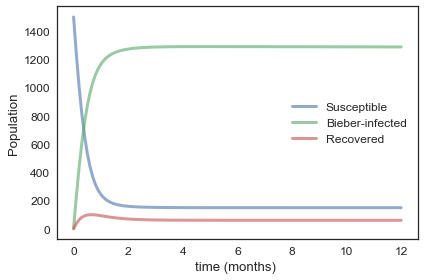

In [5]:
system = make_system(10, .00083, 1/144,1/24 , 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time (months) ", ylabel = "Population");


The above graph displays the model we replicated from the original paper. We produced the same results as the paper for this boredom rate, 1/24. The results are similar to those published in the paper.

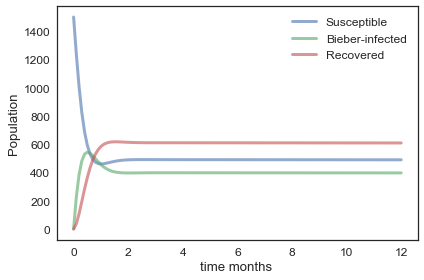

In [6]:
system = make_system(10, .00083, 1/144,2 , 2, 1, .75,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func);
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time months ", ylabel = "Population");

This graph shows the same model as the one in the graph above, only here we have increases the boredom from 1/24 to 2. Again, we plotted this graph to show that we have successfully replicated the simulations we saw in the paper. In this version of the model, the high rate of boredom 

For the sake of comparison later, we want note that in the model with slower boredom the diseased population approaches a higher equilibrium than those of the susceptible of recovered populations. We notice the opposite effect with the fast boredom case.

# Change One: Introduction of Haters

Due to his enourmous popularity, Justin Bieber has gathered a number of people who dislike him for no reason other than to rebel against what they percieve to be the mainstream. These "haters" act almost as "infected" as our Bieber fans. The difference is, the hater population is dependant on the fan population. We expand our model from three stocks, S,B, and R; to four, S, B, R, and H. 
## Grammar check here

In [7]:
def make_system_H(pi, Beta, mu, b ,P, N, epsilon, gamma, dt):
    """Make a system object for the SBR model.
    S: Susceptible
    B: Bieber-infected
    R: Recovered
    pi: Recruitment Rate
    Beta: Transmission Rate
    mu: Maturation Rate
    b: Boredom Rate
    P: Positive Media Rate
    N: Negative Media Rate
    epsilon: Positive Media Proportion
    gamma = Hater rate
    
    returns: System object
    """
    init = State(S = 1500, B = 3, R = 0, H = 3);

    t0 = 0;
    t_end = 100;
    
    return System(init=init, t0=t0, t_end=t_end,
                  pi =pi, 
                  Beta = Beta, 
                  mu = mu,
                  b  = b,
                  P = P,
                  N = N, 
                  epsilon= epsilon,
                  gamma = gamma, dt=dt);

The function "make_system_H" makes a similar system to the original one. The difference is the parameter gamma, which controls the rate at which the suceptible population become "haters."

In [8]:
def update_func_H(state, t, system):
    """Update the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R,H = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*N
    
    ds = entranceRate - infectedRate - posMediaPercent*S + negMediaPercent*B + posMediaPercent*R - negMediaPercent*S - mu*S -gamma*B
    db = infectedRate + posMediaPercent*S - negMediaPercent*B - b*B - mu*B # paper says R but should be B
    dr = b*B - posMediaPercent*R - mu*R
    dh = negMediaPercent*S + gamma*B - b*H - mu*H
    
    S += ds*dt
    B += db*dt
    R += dr*dt
    H += dh*dt

    return State(S = S, B = B, R = R, H = H);

This new update function included a new differential equation for our hater population. Haters come from suceptible due to negative media coverage relating to Bieber, this rate is represented by the "negMediaPercent\*S"  term, or they become haters because they simply object to Biebers following, "gamma\*B". People leave the hater population when they become bored of their haterdom, "b\*H", or when they age out of our system, "mu\*H".

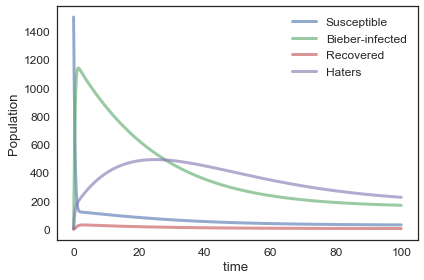

In [9]:
system = make_system_H(10, .00083, 1/144, 1/24 , 2, 1, .75, 0.01, .1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_H);

plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");
plot(frame.H, label = "Haters");
decorate(xlabel = "time ", ylabel = "Population");

The model above shows the incorporation of Bieber Haters.

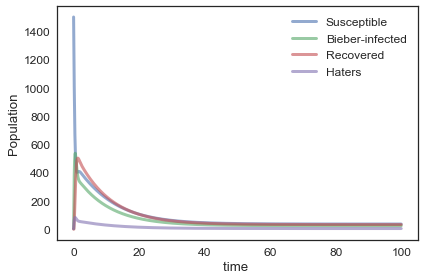

In [10]:
system = make_system_H(10, .00083, 1/144, 2, 2, 1, .75,.01,.1) #Given Parameters and dt set to 1/24 such that time is represented in hours
frame = run_simulation(system, update_func_H)
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");
plot(frame.H, label = "Haters");

decorate(xlabel = "time ", ylabel = "Population");

## Sweeping Boredom

Below we begin our first parameter sweep. Boredom controls the retention of the fan and hater populations. As boredom is increased, we expect to see both fans and haters leave their respective groups more quickly. 

In [ ]:
def sweep_b(pi, Beta, mu, b_array ,P, N, epsilon, gamma, dt):
    """Sweep a range of values for b.
    
    beta_array: array of boredom values
    
    returns: 
    sweepB: sweepSeries that maps from b to max infected with main disease
    sweepH: sweepSeries that maps from b to max infected with hater disease
    """
    sweepB = SweepSeries()
    sweepH = SweepSeries()

    for b in b_array:
        system = make_system_H(pi, Beta, mu, b ,P, N, epsilon, gamma, dt)
        frame = run_simulation(system, update_func_H)
        sweepB[system.b] = frame.B.mean()
        sweepH[system.b] = frame.H.mean()
        
    return sweepB, sweepH;

In [ ]:
boredom_array = linrange(0,2,.01) 
sweepB, sweepH = sweep_b(10, .00083, 1/144, boredom_array, 2, 1, .75,.01,.1);

In [ ]:
plot(sweepB, label = "Bieber-infected",color = "r");
plot(sweepH, label = "Haters",color = "b");
decorate(xlabel = "Boredom", ylabel = "Population");

This graph outputs the expected results of having the average population drop down as boredom increases. 

# Sweeping the Ratio of Positive/Negative Media

In [ ]:
def sweep_Media_Ratio(pi, Beta, mu, b ,P, N, e_array, gamma, dt):
    """Sweep a range of values for e.
    
    e_array: array of epsilon values

    
    returns: 
    sweepB: sweepSeries that maps from b to max infected with main disease
    sweepH: sweepSeries that maps from b to max infected with hater disease
    """
    sweepB = SweepSeries()
    sweepH = SweepSeries()
    for e in e_array:
        system = make_system_H(pi, Beta, mu, b ,P, N, e,gamma, dt)
        frame = run_simulation(system, update_func_H) # Figure out what we actually want to measure here. Figure out which metric is best
        sweepB[system.epsilon] = frame.B.mean()
        sweepH[system.epsilon] = frame.H.mean()
        
    return sweepB, sweepH;

In [ ]:
e_array = linrange(0,1,.01);

sweepB,sweepH = sweep_Media_Ratio(10, .00083, 1/144, 1/24, 2, 1, e_array,.01,.1);

In [ ]:
plot(sweepB, label = "Bieber-infected",color = "r");
plot(sweepH, label = "Haters",color = "b");

decorate(xlabel = "Ratio of Positive to Negative Media", ylabel = "Population");

This graph, showing the relationship between media and hater population, follows generally what we would expect. When the ratio of positive to negative media is under .5 the hater population thrives on the negative media. After crossing .5 the Bieber infected population surges with the increase in positive media. The Haters continue around the same level thriving off of the elavated Bieber fan levels. However, with the lack of much negative news their population begin to drop off towards complete Media saturation. 




### ODE STUFFS

In [ ]:
def slope_func(state, t, system):
    """Slope of the SBR model.
    
    state: State (S,B,R)
    t: time
    system: System object
    
    returns: State (S,B,R)
    """
    unpack(system)
    S,B,R = state;
    entranceRate = pi # people that enter the system per month
    infectedRate = Beta*S*B # number of people infected each month
    posMediaPercent = epsilon*P
    negMediaPercent = (1-epsilon)*P
    boredom = b*B
    ds = entranceRate - infectedRate  - mu*S
    db = infectedRate - boredom - mu*B # paper says R but should be B
    dr = boredom- mu*R
  

    return ds,db,dr;

In [ ]:
slope_func(init, 0, system)

In [ ]:
system = make_system(10, .00083, 1/144, 1/24, 2, 1, .75,1)
results, details = run_ode_solver(system, slope_func)
details

In [ ]:
plot(frame.S, label  = "Susceptible");
plot(frame.B, label = "Bieber-infected");
plot(frame.R, label = "Recovered");

decorate(xlabel = "time ", ylabel = "Population");

# Interpretation

We feel our model is acurate for a number of reasons. First off, in the absence of haters and negative media it matches the results from the paper exactly. When haters are added their interactions in the model are plausible. The hater population reacts to the fan population in a realistic way. We also think the sweeps of boredom and media coverage are realistic representations of what would happen. When boredom is swept from 0 to 2, (this actually didn't make sense to me). The third graph, showing how the type of media coverage effects opinions, showed what we expected: positive media is good for Bieber fans and negative media is good for Bieber haters. 

# Abstract

We expanded the SIR model to include four stocks and several new flows. We have suceptible, Bieber-fan, recovered and Bieber-hater populations. They are influenced by each other, the media, and time. Our model shows us that ultimately, given enough time, the levels of fans, haters, suceptible and recovered become constant. Our sweeps show the power the media has as an influence of public opinion and the effect boredom can have on a fan base. 